# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


In [1]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

In [2]:
from GDP_lib import root_dir

---

# Embedded OU processes: Viggiano et al. 2020

We generate timeseries corresponding to their equations (2.14-2.18).

In [3]:
# root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "synthetic_traj_ou.zarr")
ds = xr.open_zarr(path, decode_timedelta=False).persist()
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 100, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  0.041666666666666664

In [4]:
ds.freq_time.attrs = {"units": "cpd", "long_name": "f"}

---

# Adding white noise to velocity

Generating white noise to add to position or velocity

In [5]:
noise_std = 1.0

# first method: common noise realization
# from numpy.random import randn
# ds["noise_c"] = ("time", randn(ds.time.size)*noise_std)

l = []
S = [3, 1009, 2034, 4304]
for i in range(ds.T.size):
    l.append(ts.normal(time=ds.time, draws=ds.draw.size, seed=S[i]) * noise_std)
ds["noise_i"] = xr.concat(l, dim="T")
# second method: independent noise realizations
# scale represents the noise
# ds["noise_i"] = ts.normal(time = ds.time, draws=ds.draw.size)#, dummy_dims = dict(T=ds.T.size))*noise_std
ds["noise_i"].attrs = {"description": f"white noise with std={noise_std}"}
# ds["dnoise_i"].attrs = {'description':f'white noise time differentiation with std={noise_std}'}

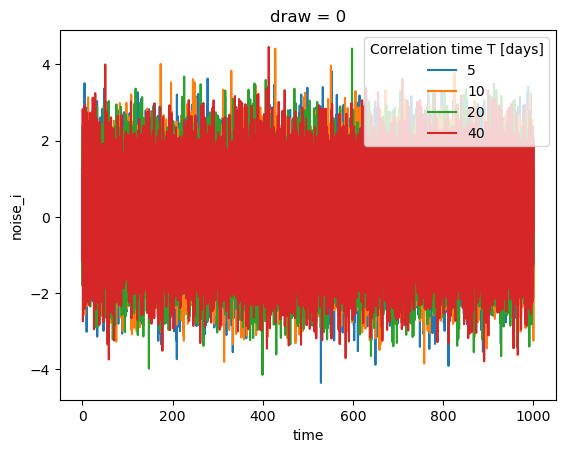

In [6]:
ds.noise_i.isel(draw=0).plot(hue="T")

In [7]:
ds.noise_i.where(ds.noise_i == np.nan, drop=True)

<xarray.DataArray 'noise_i' (T: 0, time: 0, draw: 0)>
dask.array<where, shape=(0, 0, 0), dtype=float64, chunksize=(0, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) int64 
  * draw     (draw) int64 
  * time     (time) float64 
Attributes:
    description:  white noise with std=1.0

In [8]:
def add_noised_vel_var(ds, noise, suffix, std_noise):

    ds["u" + suffix] = ds["u"] + ds[noise] * std_noise
    ds["x" + suffix] = (
        ds["u" + suffix].cumulative_integrate("time").assign_attrs(units="m") * 86400
    )
    ds["a" + suffix] = (
        ds["u" + suffix].differentiate("time").assign_attrs(units="m/s^2") / 86400
    )  # rescale in m/s

    ds["nu" + suffix] = ds[noise] * std_noise
    ds["nx" + suffix] = (
        ds["nu" + suffix].cumulative_integrate("time").assign_attrs(units="m") * 86400
    )
    ds["na" + suffix] = (
        ds["nu" + suffix].differentiate("time").assign_attrs(units="m/s^2") / 86400
    )  # rescale in m/s

    ds["u" + suffix].attrs = {
        "description": "u +" + noise + f"{std_noise}m/s",
        "noise_std": std_noise,
    }
    ds["x" + suffix].attrs = {
        "description": "x from cumulative integration of u +"
        + noise
        + f"{std_noise}m/s"
    }
    ds["a" + suffix].attrs = {
        "description": "a from differentiation of u +" + noise + f"{std_noise}m/s"
    }
    ds["nu" + suffix].attrs = {
        "description": noise + f"{std_noise}m/s",
        "noise_std": std_noise,
    }
    ds["nx" + suffix].attrs = {
        "description": "noise on x from cumulative integration of "
        + noise
        + f"{std_noise}m/s"
    }
    ds["na" + suffix].attrs = {
        "description": "noise on a from differentiation of " + noise + f"{std_noise}m/s"
    }

    # compute autocorrelations
    ds["xx" + suffix] = sigp.correlate(ds["x" + suffix], ds["x" + suffix]).persist()
    ds["uu" + suffix] = sigp.correlate(ds["u" + suffix], ds["u" + suffix]).persist()
    ds["aa" + suffix] = sigp.correlate(ds["a" + suffix], ds["a" + suffix]).persist()
    ds["nxnx" + suffix] = sigp.correlate(ds["nx" + suffix], ds["nx" + suffix]).persist()
    ds["nunu" + suffix] = sigp.correlate(ds["nu" + suffix], ds["nu" + suffix]).persist()
    ds["nana" + suffix] = sigp.correlate(ds["na" + suffix], ds["na" + suffix]).persist()

    # compute spectra
    ds["Ex" + suffix] = sigp.spectrum_welch(ds["x" + suffix], T=100)[0]
    ds["Eu" + suffix] = sigp.spectrum_welch(ds["u" + suffix], T=100)[0]
    ds["Ea" + suffix] = sigp.spectrum_welch(ds["a" + suffix], T=100)[0]
    ds["Enx" + suffix] = sigp.spectrum_welch(ds["nx" + suffix], T=100)[0]
    ds["Enu" + suffix] = sigp.spectrum_welch(ds["nu" + suffix], T=100)[0]
    ds["Ena" + suffix] = sigp.spectrum_welch(ds["na" + suffix], T=100)[0]


def add_noised_pos_var(ds, noise, suffix, std_noise):

    ds["x" + suffix] = ds["x"] + ds[noise] * std_noise
    ds["u" + suffix] = (
        ds["x" + suffix].differentiate("time").assign_attrs(units="m/s") / 86400
    )  # rescale in m/s
    ds["a" + suffix] = (
        ds["u" + suffix].differentiate("time").assign_attrs(units="m/s^2") / 86400
    )  # rescale in m^2/s
    ds["nx" + suffix] = ds[noise] * std_noise
    ds["nu" + suffix] = (
        ds["nx" + suffix].differentiate("time").assign_attrs(units="m/s") / 86400
    )  # rescale in m/s
    ds["na" + suffix] = (
        ds["nu" + suffix].differentiate("time").assign_attrs(units="m/s^2") / 86400
    )  # rescale in m^2/s

    ds["x" + suffix].attrs = {
        "description": "x +" + noise + f"{std_noise}m",
        "noise_std": std_noise,
    }
    ds["u" + suffix].attrs = {
        "description": "x from differention of x +" + noise + f"{std_noise}m"
    }
    ds["a" + suffix].attrs = {
        "description": "a from double differentiation of x +" + noise + f"{std_noise}m"
    }
    ds["nu" + suffix].attrs = {
        "description": noise + f"{std_noise}m",
        "noise_std": std_noise,
    }
    ds["nx" + suffix].attrs = {
        "description": "noise on x from differentiation of " + noise + f"{std_noise}m"
    }
    ds["na" + suffix].attrs = {
        "description": "noise on a from differentiation of " + noise + f"{std_noise}m"
    }

    # compute autocorrelations
    ds["xx" + suffix] = sigp.correlate(ds["x" + suffix], ds["x" + suffix]).persist()
    ds["uu" + suffix] = sigp.correlate(ds["u" + suffix], ds["u" + suffix]).persist()
    ds["aa" + suffix] = sigp.correlate(ds["a" + suffix], ds["a" + suffix]).persist()
    ds["nxnx" + suffix] = sigp.correlate(ds["nx" + suffix], ds["nx" + suffix]).persist()
    ds["nunu" + suffix] = sigp.correlate(ds["nu" + suffix], ds["nu" + suffix]).persist()
    ds["nana" + suffix] = sigp.correlate(ds["na" + suffix], ds["na" + suffix]).persist()

    # compute spectra
    Ex, omega = sigp.spectrum_welch(ds["x" + suffix], T=100)
    Eu, omega = sigp.spectrum_welch(ds["u" + suffix], T=100)
    Ea, omega = sigp.spectrum_welch(ds["a" + suffix], T=100)
    ds["Enx" + suffix] = sigp.spectrum_welch(ds["nx" + suffix], T=100)[0]
    ds["Enu" + suffix] = sigp.spectrum_welch(ds["nu" + suffix], T=100)[0]
    ds["Ena" + suffix] = sigp.spectrum_welch(ds["na" + suffix], T=100)[0]
    ds["Ex" + suffix] = Ex
    ds["Eu" + suffix] = Eu
    ds["Ea" + suffix] = Ea

    return ds

In [ ]:
ds.x.isel(T=2).std(dim="time").mean(dim="draw").compute()

<xarray.DataArray 'x' ()>
array(6462594.1758276)
Coordinates:
    T        int64 20

In [9]:
# std_dx = float(np.format_float_scientific(ds.x.diff(dim='time').std().values, precision = 0, exp_digits=1)) #scaling noise
# std_u = float(np.format_float_scientific(ds.u.std().values, precision = 0, exp_digits=1)) #scaling noise
std_dx = ds.x.diff(dim="time").std().values  # scaling noise
std_u = ds.u.std().values  # scaling noise
print(f"std_dx :{std_dx}, std_u :{std_u}")
std_noise_x = [0.25, 0.5, 0.75, 1]

std_noise_u = [0.25, 0.5, 0.75, 1]
suffixes_x = [f"_nx{n}".replace(".", "") for n in std_noise_x]
suffixes_u = [f"_nu{n}".replace(".", "") for n in std_noise_u]

# Building suffixes_legend dict for easier plotting
suffixes_leg_x = {
    i: r"$\sigma_{\epsilon} =" + i.replace("_nx", "").replace("0", "0.") + r"\sigma_x$"
    for i in suffixes_x
}
suffixes_leg_u = {
    i: r"$\sigma_{\epsilon} =" + i.replace("_nu", "").replace("0", "0.") + r"\sigma_u$"
    for i in suffixes_u
}
suffixes_leg = {**suffixes_leg_x, **suffixes_leg_u}

std_dx :3672.9449523993853, std_u :1.020415462689995


In [10]:
dsn = ds.copy()

In [11]:
for i in range(len(std_noise_x)):
    add_noised_pos_var(dsn, "noise_i", suffixes_x[i], std_noise_x[i] * std_dx)
for i in range(len(std_noise_u)):
    add_noised_vel_var(dsn, "noise_i", suffixes_u[i], std_noise_u[i] * std_u)

In [12]:
dsn

<xarray.Dataset>
Dimensions:     (T: 4, draw: 100, freq_time: 2400, lags: 24000, time: 24000)
Coordinates:
  * T           (T) int64 5 10 20 40
  * draw        (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time   (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/154)
    Ea          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Eu          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ex          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    a           (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    aa          (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    u           (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    ...          ...
    Ex_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Eu_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Ea_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Enx_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Enu_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Ena_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  0.041666666666666664

In [13]:
dsn["T"].attrs = ds["T"].attrs
dsn["freq_time"].attrs = ds["freq_time"].attrs
dsn["time"].attrs = ds["time"].attrs
dsn["lags"].attrs = ds["lags"].attrs
dsn = dsn.assign_attrs(
    {
        "noise_suffixe_description": r"_n + variable $v$ to which the white noised is added + multipling ratio $Amp$ without point, the noise std is $Amp \times \sigma_v$",
        "noise_suffixes_legend": suffixes_leg,
    }
)

In [14]:
dsn = dsn.persist()
dsn

<xarray.Dataset>
Dimensions:     (T: 4, draw: 100, freq_time: 2400, lags: 24000, time: 24000)
Coordinates:
  * T           (T) int64 5 10 20 40
  * draw        (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * freq_time   (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/154)
    Ea          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Eu          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    Ex          (T, draw, freq_time) float64 dask.array<chunksize=(4, 100, 2400), meta=np.ndarray>
    a           (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    aa          (T, draw, lags) float64 dask.array<chunksize=(4, 100, 5000), meta=np.ndarray>
    u           (T, time, draw) float64 dask.array<chunksize=(4, 5000, 100), meta=np.ndarray>
    ...          ...
    Ex_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Eu_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Ea_nu1      (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Enx_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Enu_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
    Ena_nu1     (T, draw, freq_time) float64 dask.array<chunksize=(1, 100, 2400), meta=np.ndarray>
Attributes:
    description:                synthetic trajectories simulated via the embe...
    n_layers:                   5
    sigma_u:                    1
    tau_eta_days:               0.041666666666666664
    noise_suffixe_description:  _n + variable $v$ to which the white noised i...
    noise_suffixes_legend:      {'_nx025': '$\\sigma_{\\epsilon} =0.25\\sigma...

In [15]:
# Verify Nan values
dsn.nx_nx1.where(dsn.nx_nx1 == np.nan, drop=True)

<xarray.DataArray 'nx_nx1' (T: 0, time: 0, draw: 0)>
dask.array<where, shape=(0, 0, 0), dtype=float64, chunksize=(0, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) int64 
  * draw     (draw) int64 
  * time     (time) float64 
Attributes:
    description:  noise on x from differentiation of noise_i3672.9449523993853m

In [16]:
# root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "noised_synthetic_traj_ou.zarr")
dsn.chunk({"T": -1, "time": 5000, "draw": -1, "lags": 5000}).to_zarr(path, mode="w")